# Examen Python data developer
# Deel 1
## Introductie
Voor dit examen is het belangrijk dat je volgende zaken zeker doet:
 - Maak een Vitual Environment aan & exporteer een `.yml` (of soortgelijke) file aan die je toevoegt aan je codebase.
 - Maak een github pagina aan met een bijhorende `.gitignore` en `readme.md`. Voeg een link naar de github repo toe aan je readme file.
 - Zorg dat je op het einde de tijd neemt om je code op te schonen zodat deze begrijpelijk is voor derden.
 - Wanneer je klaar bent, maak een `.zip` bestand van je volledige codebase aan en laad deze op in de leeromgeving.

In deze opgave bekijken we een gesimuleerde dataset over de geboortes in België van 2019. De data is te vinden in `.csv` bestanden die gelabeld zijn met de echte geboortedag van de personen in het bestand. Laat ons bijvoorbeeld even kijken naar de eerste 5 lijnen van het bestand `2019-1-1.csv`:

<table align="center">
  <tr>
    <th>gemeente</th>
    <th>naam</th>
    <th>geslacht</th>
    <th>verwachte datum</th>
  </tr>
  <tr>
    <td>Hooglede</td>
    <td>Elias</td>
    <td>Mannelijk</td>
    <td>01/14/2019</td>
  </tr>
  <tr>
    <td>Sint-Niklaas (Sint-Niklaas)</td>
    <td>Pauline</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Wijnegem</td>
    <td>Anita</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Grâce-Hollogne</td>
    <td>Jean-Paul</td>
    <td>Mannelijk</td>
    <td>01/13/2019</td>
  </tr>
  <tr>
    <td>Boussu</td>
    <td>François</td>
    <td>Mannelijk</td>
    <td>01/26/2019</td>
  </tr>
</table>


Hier hebben we de kolommen:
 - **gemeente**: De gemeente waar de persoon geboren is.
 - **naam**: De voornaam van de persoon.
 - **geslacht**: Het geslacht van de persoon (Mannelijk of Vrouwelijk).
 - **verwachte datum**: De verwachte geboortedatum van de persoon.

Dus hier hebben we dan bijvoorbeeld op de eerste lijn de mannelijke persoon Elias die geboren is in Hooglede waarvan men verwachtte dat hij zou geboren worden op `01/14/2019` (Amerikaans formaat) maar in feite geboren is op 1 januari 2019.

Doorheen deze opgave gaan we de data van dichterbij inspecteren! Je kan deze opgaves alternatief lezen in de bijgeleverde notebook `examen.ipynb` waar ook de (meeste) afbeeldingen & resultaten zichtbaar zijn.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# Custom scripts
sys.path.append('../scripts')  # Adjust the path accordingly
from read_data import read_csv_files
from make_a_chart import lineplot
from make_a_chart import barplot
from make_a_chart import horizontal_bar_plot
from make_a_chart import histogram_plot
from outliers import calculate_wrong_outliers
from outliers import handle_wrong_outliers
from outliers import calculate_other_outliers

# Define data locatons
rootdir = os.path.join(os.getcwd(), '../')
input_path = os.path.join(rootdir, 'data', 'input')
output_path = os.path.join(rootdir, 'data', 'output')

## Utilities

In [2]:
def to_percentage(number):
    return str(np.round(number * 100, 2)) + "%"

def compute_num_unique(df, n_births):
    return len(np.unique(df['naam'].sample(n_births)))

## Stap 1: data inlezen

Maak een lus over alle bestanden in de map `data/geboortes`, lees elk `.csv` bestand in en voeg deze samen tot 1 grote DataFrame. Merk op dat de datum verwerkt zit in de filename, voeg deze toe aan de kleine DataFrames voor je de dataframes samenvoegt met een `pd.concat(dfs)`.

Voeg een extra kolom toe met een `"dag van het jaar"` getal, dus 1 januari 2019 is `1`, 2 januari 2019 is `2`, enzovoort.

**Opmerking**: Er is ook data voor 29 februari 2019, terwijl dit geen schrikkeljaar is! Plaats deze geboortes in een afzonderlijke DataFrame `df_wrong`. Zet in `df_wrong` een extra kolom met een referentie naar waarom deze data foutief is.

In [3]:
# Read all .csv files, put them in a df, add (and rename) the column "dag geboorte"
births_df = (read_csv_files(input_path)
             .rename(columns={'file_name': 'dag geboorte'}))

# Put 2019-2-29 in df_wrong, keep other records in births_df
df_wrong = births_df[births_df['dag geboorte'] == "2019-2-29"].copy()
df_wrong["reden foutief"] = "Onbestaande geboortedag"
births_df = births_df[births_df['dag geboorte'] != "2019-2-29"]

### Data quality checks

In [4]:
births_df.describe()

,gemeente,naam,geslacht,verwachte datum,dag geboorte
count,116850,116850,116850,116850,116850
unique,579,5255,2,427,365
top,Antwerpen,Maria,Mannelijk,07/06/2019,2019-7-1
freq,6051,1627,58932,399,923


In [5]:
births_df.dtypes

gemeente           object
naam               object
geslacht           object
verwachte datum    object
dag geboorte       object
dtype: object

In [6]:
births_df.isnull().sum()

gemeente           0
naam               0
geslacht           0
verwachte datum    0
dag geboorte       0
dtype: int64

### Omzetten naar datetimes & toevoegen "dag van het jaar"

Vooraleer we 'dag van het jaar' kunnen toevoegen, moeten we datums eerst omzetten naar datetimes.

In [7]:
# Convert strings to datetimes
births_df['verwachte datum'] = pd.to_datetime(births_df['verwachte datum'], format='%m/%d/%Y')
births_df['dag geboorte'] = pd.to_datetime(births_df['dag geboorte'], format='%Y-%m-%d')

# Check the data types of the columns after conversion
print("Data types of columns in the combined DataFrame after conversion:")
print(births_df.dtypes)

Data types of columns in the combined DataFrame after conversion:
gemeente                   object
naam                       object
geslacht                   object
verwachte datum    datetime64[ns]
dag geboorte       datetime64[ns]
dtype: object


In [8]:
births_df.describe()

,verwachte datum,dag geboorte
count,116850,116850
mean,2019-07-07 01:56:36.292683008,2019-06-29 15:31:46.752246272
min,2018-12-26 00:00:00,2019-01-01 00:00:00
25%,2019-04-08 00:00:00,2019-04-01 00:00:00
50%,2019-07-06 00:00:00,2019-06-29 00:00:00
75%,2019-10-04 00:00:00,2019-09-27 00:00:00
max,2020-02-28 00:00:00,2019-12-31 00:00:00


### Kopieer dataframe en voeg extra kolommen toe

In [9]:
# Before adding new columns to the dataframe, we'll take a copy of the original
births_xtracols_df = births_df.copy()

# Change columnnames for simplicity and consistency
births_xtracols_df = births_xtracols_df.rename(columns={"verwachte datum": "datum_verwacht"})
births_xtracols_df = births_xtracols_df.rename(columns={"dag geboorte": "datum_geboorte"})

# Add new columns to the dataframe for easier future calculations
births_xtracols_df['weekdag_verwacht'] = births_xtracols_df['datum_verwacht'].dt.day_name()
births_xtracols_df['weekdag_geboorte'] = births_xtracols_df['datum_geboorte'].dt.day_name()
births_xtracols_df['dag_verwacht'] = births_xtracols_df['datum_verwacht'].dt.dayofyear
births_xtracols_df['dag_geboorte'] = births_xtracols_df['datum_geboorte'].dt.dayofyear  # ="dag van het jaar"
births_xtracols_df['verschil'] = (births_xtracols_df['datum_geboorte'] - births_xtracols_df['datum_verwacht']).dt.days

# Let's sort on 'dag van het jaar'
births_xtracols_df.sort_values(by='dag_geboorte', ascending=True, inplace=True)
births_xtracols_df.reset_index()

,index,gemeente,naam,geslacht,datum_verwacht,datum_geboorte,weekdag_verwacht,weekdag_geboorte,dag_verwacht,dag_geboorte,verschil
0,0,Hooglede,Elias,Mannelijk,2019-01-14,2019-01-01,Monday,Tuesday,14,1,-13
1,364,Scherpenheuvel-Zichem,Rudolphe,Mannelijk,2019-01-11,2019-01-01,Friday,Tuesday,11,1,-10
2,363,Courcelles,Sarah,Vrouwelijk,2019-01-02,2019-01-01,Wednesday,Tuesday,2,1,-1
3,362,Lille,Maria,Vrouwelijk,2018-12-31,2019-01-01,Monday,Tuesday,365,1,1
4,361,Koksijde,Martine,Vrouwelijk,2018-12-29,2019-01-01,Saturday,Tuesday,363,1,3
...,...,...,...,...,...,...,...,...,...,...,...
116845,35927,Balen,Ronny,Mannelijk,2019-12-30,2019-12-31,Monday,Tuesday,364,365,1
116846,35926,Mechelen,Sanae,Vrouwelijk,2020-01-05,2019-12-31,Sunday,Tuesday,5,365,-5
116847,35925,Blankenberge,Steve,Mannelijk,2019-12-27,2019-12-31,Friday,Tuesday,361,365,4
116848,35932,Kalmthout,Dirk,Mannelijk,2020-01-25,2019-12-31,Saturday,Tuesday,25,365,-25


## Stap 2: Dagelijks aantal geboortes bekijken
#### Vraag 1: Maak een plot van het aantal geboortes per dag van het jaar. 

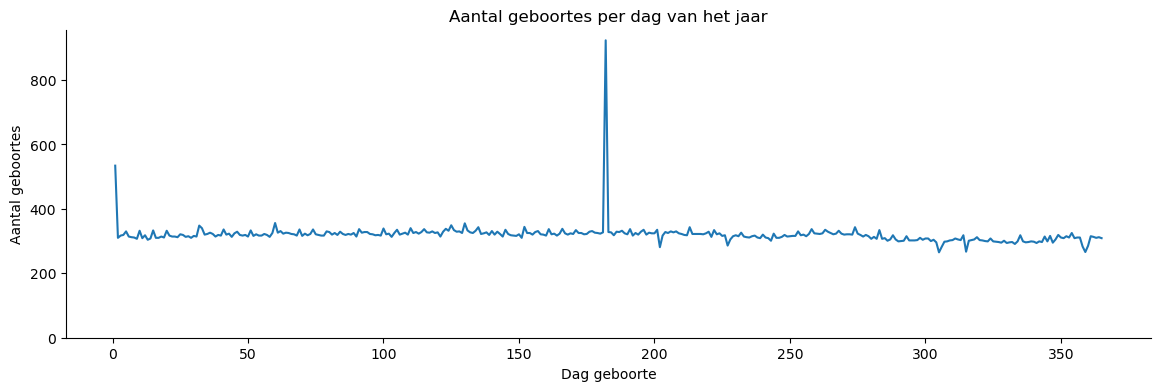

In [10]:
# Grouping by 'dag_geboorte' and counting the number of occurrences
births_per_day = (births_xtracols_df
                  .groupby('dag_geboorte')
                  .size())

# Create a lineplot
lineplot(births_per_day,
         title='Aantal geboortes per dag van het jaar',
         x_label='Dag geboorte',
         y_label='Aantal geboortes',
         set_ylim=0)

#### Vraag 2: Outliers vinden & behandelen

We klassificeren een datum als een outlier als het aantal geboortes meer dan `50%` afwijkt van de gemiddelde waarde overheen de volledige dataset. Zoek alle outliers in de dataset.

Ik zal je vertellen; de outliers op 1 januari en 1 juli komen doordat alle geboortes waarvoor de datum niet correct genoteerd is, de datum 1 januari (voor de eerste helft van het jaar) en op 1 juli (voor de tweede helft van het jaar) geplaatst worden. Om dit op te lossen, halen we in de grote geboortes DataFrame (met 1 lijn per geboorte) deze twee datums er volledig uit. Dus we gaan **alle** geboortes van 1 januari en 1 juli verwijderen uit deze dataframe en toevoegen aan de `df_wrong` dataframe met als reden `2019-01-01` en `2019-07-01`.

In [11]:
# Calculate outliers
outliers = (calculate_wrong_outliers(births_per_day)
            .reset_index()
            .rename(columns={0: "aantal geboortes"}))
print(f"\n{outliers}")

# Handle outliers
births_xtracols_cleaned_df, df_wrong_extended = handle_wrong_outliers(data=births_xtracols_df,
                                                                outliers=outliers["dag_geboorte"],
                                                                reason="Datum geboorte",
                                                                df_wrong=df_wrong)

df_wrong_extended.drop(columns=['weekdag_verwacht', 'weekdag_geboorte', 'dag_verwacht', 'verschil'], inplace=True)
df_wrong_extended.sample(10)

Gemiddeld aantal geboortes per dag: 320.1
Lower outlier threshold: 160.1 ; Upper outlier threshold: 480.2

   dag_geboorte  aantal geboortes
0             1               534
1           182               923


,gemeente,naam,geslacht,verwachte datum,dag geboorte,reden foutief,datum_verwacht,datum_geboorte
579,Berlaar,Sandra,Vrouwelijk,NaN,NaN,Datum geboorte,2019-01-14,2019-01-01
1466,Brugge,Vincent,Mannelijk,NaN,NaN,Datum geboorte,2019-07-07,2019-07-01
893,Izegem,Samuel,Mannelijk,NaN,NaN,Datum geboorte,2019-06-25,2019-07-01
506,Charleroi,Charline,Vrouwelijk,NaN,NaN,Datum geboorte,2019-01-05,2019-01-01
240,Kampenhout,Eline,Vrouwelijk,NaN,NaN,Datum geboorte,2019-01-06,2019-01-01
857,Manage,Johnny,Mannelijk,NaN,NaN,Datum geboorte,2019-07-11,2019-07-01
1069,Merelbeke,Leander,Mannelijk,NaN,NaN,Datum geboorte,2019-07-06,2019-07-01
1512,Doornik,Candice,Vrouwelijk,NaN,NaN,Datum geboorte,2019-07-07,2019-07-01
21,Mol,Marc,Mannelijk,03/15/2019,2019-2-29,Onbestaande geboortedag,NaT,NaT
623,Machelen (Halle-Vilvoorde),Jennifer,Vrouwelijk,NaN,NaN,Datum geboorte,2019-07-01,2019-07-01


In [12]:
# Quick sanity checks: A+B = C+D like it should be!
print(f"A. births_xtracols_df = Original data without wrong: {len(births_xtracols_df)}")
print(f"B. df_wrong = Wrong without 1 jan & 1 jul: {len(df_wrong)}")

print(f"\nC. births_xtracols_cleaned_df = Original data without 29 feb, 1 jan and 1 jul: {len(births_xtracols_cleaned_df)}")
print(f"D. df_wrong_extended = Wrong incl. 1 jan and 1 jul: {len(df_wrong_extended)}")

A. births_xtracols_df = Original data without wrong: 116850
B. df_wrong = Wrong without 1 jan & 1 jul: 73

C. births_xtracols_cleaned_df = Original data without 29 feb, 1 jan and 1 jul: 115393
D. df_wrong_extended = Wrong incl. 1 jan and 1 jul: 1530


Maak dezelfde plot nu opnieuw met het aantal geboortes per dag.

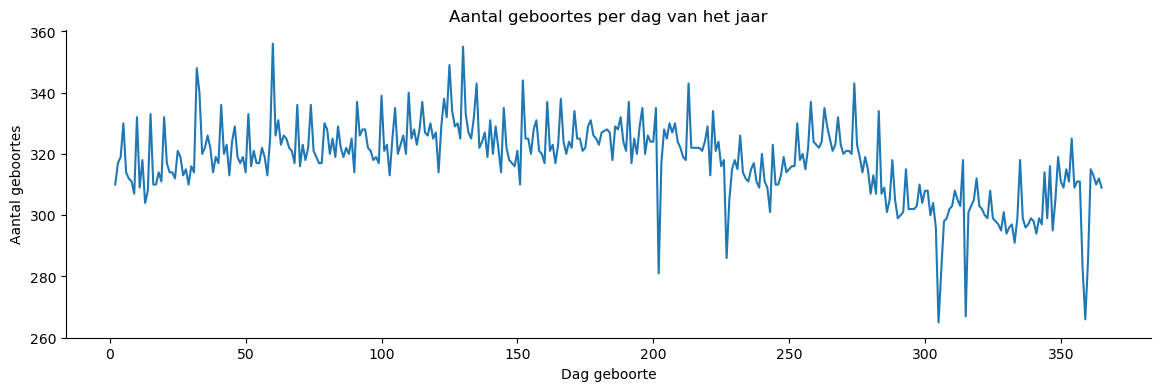

In [13]:
# Grouping by 'dag van het jaar' and counting the number of occurrences
births_per_day_cleaned = (births_xtracols_cleaned_df
                  .groupby('dag_geboorte')
                  .size())

# Create a lineplot without 1 januari and 1 july
lineplot(births_per_day_cleaned,
         title='Aantal geboortes per dag van het jaar',
         x_label='Dag geboorte',
         y_label='Aantal geboortes',
         set_ylim=260)

 We zien dat er nog steeds redelijk wat uitschieters zijn, kan je code schrijven om de 8 extreme uitschieters in de 2e helft van het jaar identificeren?

In [14]:
other_outliers = calculate_other_outliers(births_xtracols_cleaned_df)

other_outliers

,datum_geboorte,aantal geboortes
0,2019-07-21,281
1,2019-08-15,286
2,2019-11-01,265
3,2019-11-02,282
4,2019-11-11,267
5,2019-12-24,283
6,2019-12-25,266
7,2019-12-26,285


### Bonusvraag: wekelijkse verbanden

We zien vele pieken en dalen in de evolutie van het aantal geboortes. We willen deze grafiek graag iets "gladder" maken. Kan je hiervoor eens een visualizatie maken van het **gemiddeld** aantal geboortes per week (dit voor elke week, dus maandag-maandag, dinsdag-dinsdag, woensdag-woensdag, ...).

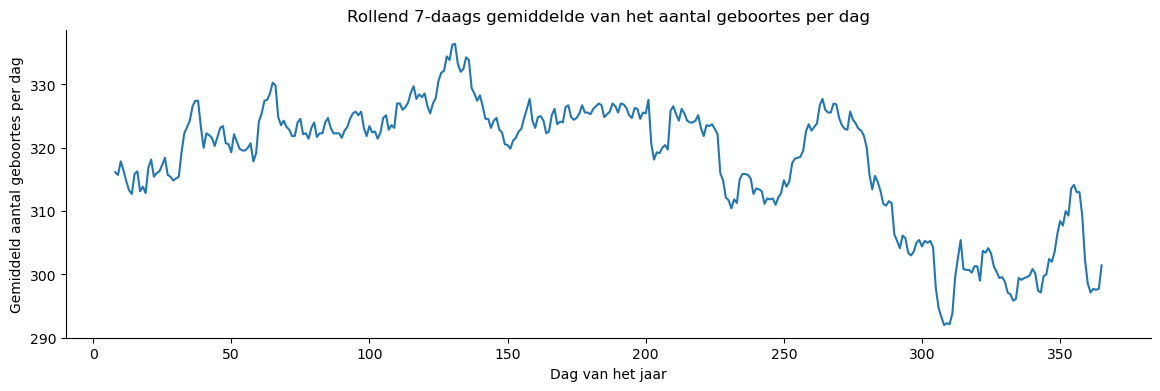

In [15]:
# Set 'dag geboorte' as the index without using inplace=True
births_xtracols_cleaned_rolling = births_per_day_cleaned.rolling(window=7, min_periods=1).mean()

# Omit the first 6 days -> rolling mean will be too low because less than 7 days are in it!
births_xtracols_cleaned_rolling = births_xtracols_cleaned_rolling.iloc[6:]

# Plot the rolling sum
lineplot(births_xtracols_cleaned_rolling,
         title='Rollend 7-daags gemiddelde van het aantal geboortes per dag',
         x_label='Dag van het jaar',
         y_label='Gemiddeld aantal geboortes per dag',
         set_ylim=290)

Dat ziet er al een stuk mooier uit!  We zien ook een aantal duidelijk dips & pieken verschijnen die we eerder niet zagen. We kunnen nu ook even kijken naar het gemiddeld aantal geboortes per dag van de week! Misschien worden er wel gewoon veel minder mensen geboren op zondag dan een andere dag?

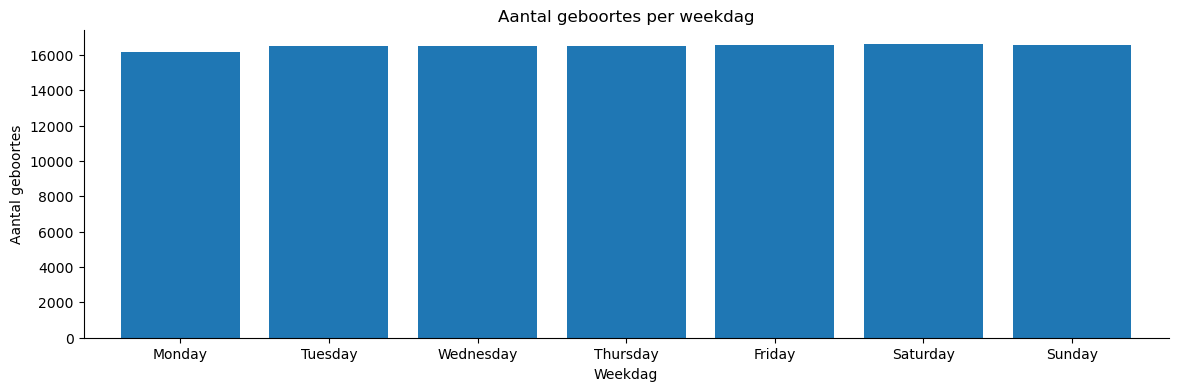

In [16]:
# Define the desired order of the days of the week
desired_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Calculate total births for each day of the week
births_per_weekday = (births_xtracols_cleaned_df
                      .groupby("weekdag_geboorte")
                      .size()
                      .reindex(desired_order))

barplot(births_per_weekday, 
        title='Aantal geboortes per weekdag',
        x_label='Weekdag',
        y_label='Aantal geboortes',
        width=0.8)

# Deel 2

# Mag weg

### Verschil in dagen tussen werkelijke en verwachte geboortedata

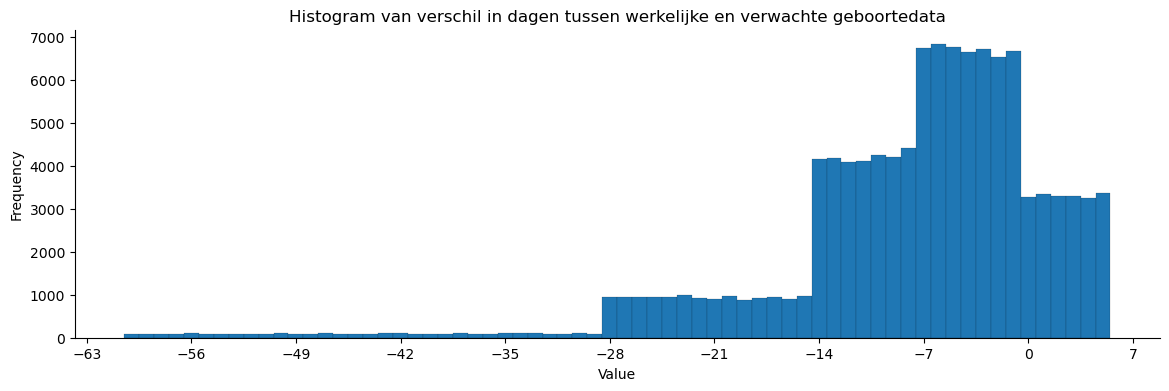

-60

In [18]:
histogram_plot(data=births_xtracols_cleaned_df['verschil'], 
               title="Histogram van verschil in dagen tussen werkelijke en verwachte geboortedata", 
               x_label="Value",
               y_label="Frequency", 
               num_bins=np.arange(births_xtracols_cleaned_df['verschil'].min() - 0.5, births_xtracols_cleaned_df['verschil'].max() + 0.5),
               xticks=np.arange(7, births_xtracols_cleaned_df['verschil'].min()-7, -7))

births_xtracols_cleaned_df['verschil'].min() 

### Top-10 gemeentes met de meeste geboorten

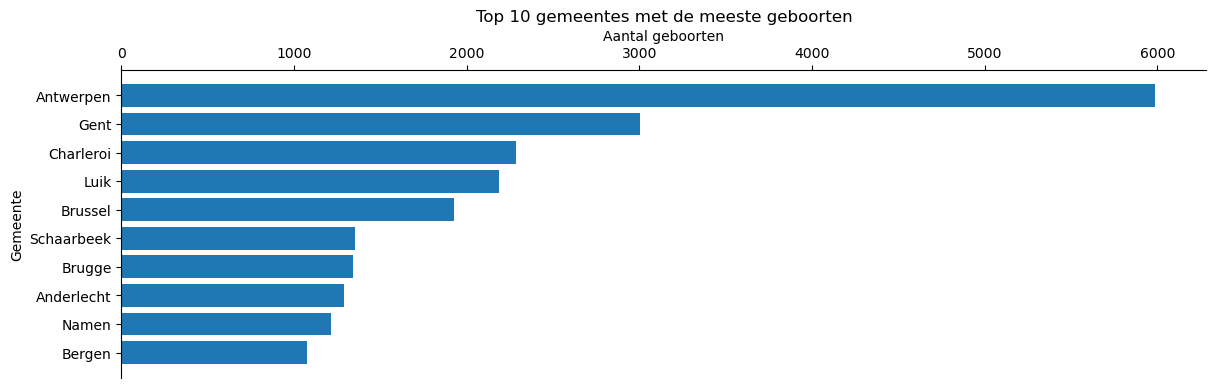

In [39]:
# Group by 'gemeente' and count the number of births
gemeente_counts = births_xtracols_cleaned_df.groupby('gemeente').size().sort_values(ascending=False)

# Select top 10 municipalities
top_10_gemeentes = gemeente_counts.head(10)

horizontal_bar_plot(data=top_10_gemeentes, 
                    title="Top 10 gemeentes met de meeste geboorten", 
                    x_label="Aantal geboorten", 
                    y_label="Gemeente")

### Zijn er veranderingen in de verhouding tussen jongens en meisjes die worden geboren gedurende het jaar?

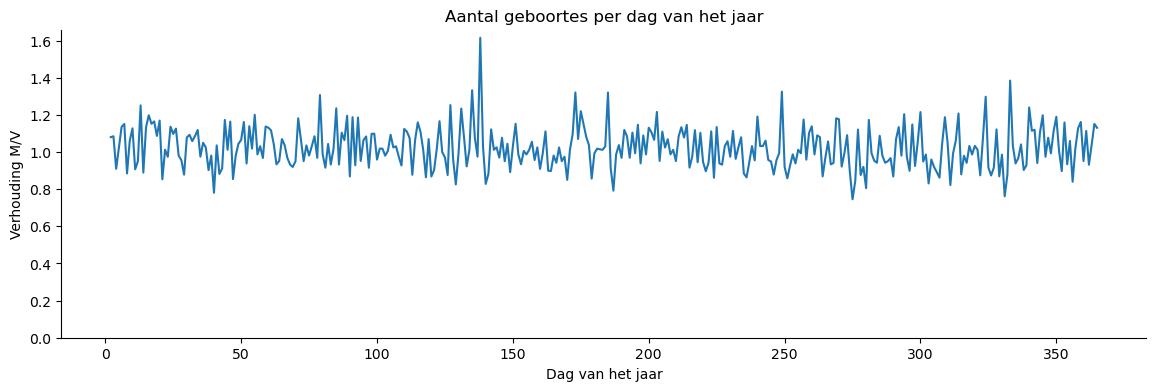

In [40]:
# Calculate the number of births per gender per day
births_per_day = (births_xtracols_cleaned_df
                  .groupby(['dag_geboorte', 'geslacht'])
                  .size()
                  .unstack())

# Calculate the ratio of boys to girls per day
births_per_day['ratio'] = births_per_day['Mannelijk'] / births_per_day['Vrouwelijk']

# Create a lineplot
lineplot(births_per_day['ratio'],
         title='Aantal geboortes per dag van het jaar',
         x_label='Dag van het jaar',
         y_label='Verhouding M/V',
         set_ylim=0)

### Top-10 gemeentes met grootste en kleinste verhouding M/V (Geslacht per gemeente)

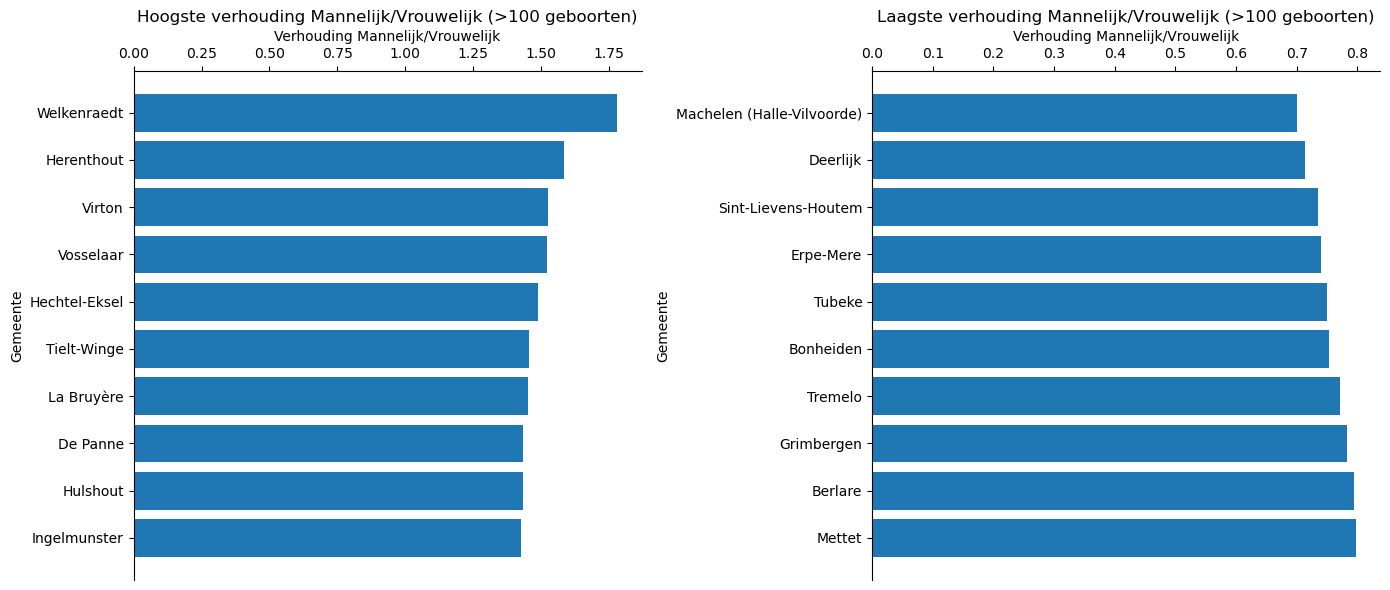

In [41]:
gemeente_counts = (births_xtracols_cleaned_df
                   .groupby(['gemeente', 'geslacht'])
                   .size()
                   .unstack(fill_value=0))

# Calculate the total births per municipality
gemeente_counts['total'] = gemeente_counts.sum(axis=1)

# Filter municipalities with more than 100 births
gemeente_counts = gemeente_counts[gemeente_counts['total'] > 100]

# Calculate the ratio of male to female births per municipality
gemeente_counts['ratio_mannelijk_vrouwelijk'] = gemeente_counts['Mannelijk'] / gemeente_counts['Vrouwelijk']

# Select the top 10 municipalities with the highest ratio
top_10_ratios = gemeente_counts['ratio_mannelijk_vrouwelijk'].nlargest(10)
bottom_10_ratios = gemeente_counts['ratio_mannelijk_vrouwelijk'].nsmallest(10)

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left subplot for top 10 ratios
horizontal_bar_plot(data=top_10_ratios,
                    title="Hoogste verhouding Mannelijk/Vrouwelijk (>100 geboorten)", 
                    x_label="Verhouding Mannelijk/Vrouwelijk", 
                    y_label="Gemeente", 
                    axes=axes[0])

# Right subplot for bottom 10 ratios
horizontal_bar_plot(data=bottom_10_ratios,
                    title="Laagste verhouding Mannelijk/Vrouwelijk (>100 geboorten)",
                    x_label="Verhouding Mannelijk/Vrouwelijk",
                    y_label="Gemeente",
                    axes=axes[1])

plt.tight_layout()
plt.show()

### Naamverdeling

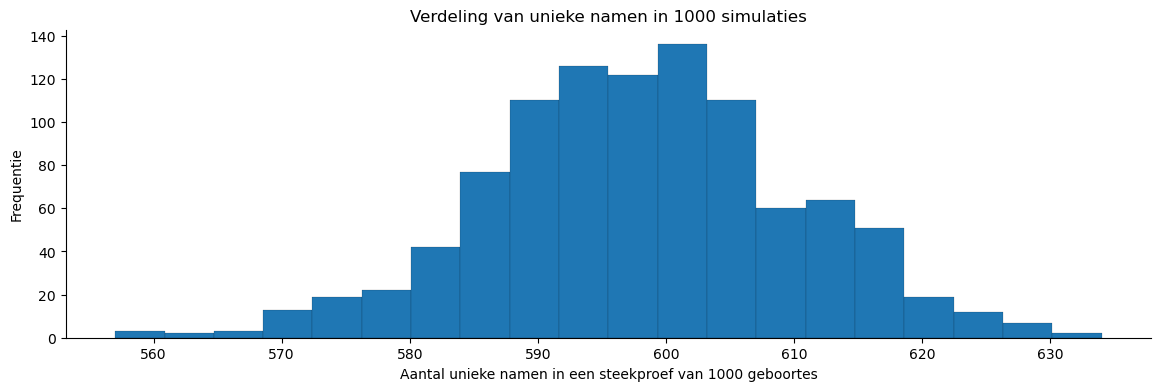

In [42]:
# Number of simulations
num_simulations = 1000

# Results storage
unique_names_counts = []

# Perform simulations
for _ in range(num_simulations):
    unique_names_count = compute_num_unique(births_xtracols_cleaned_df, 1000)
    unique_names_counts.append(unique_names_count)

# Create a histogram with adjusted number of bins if necessary
histogram_plot(data=unique_names_counts,
               title="Verdeling van unieke namen in 1000 simulaties", 
               x_label="Aantal unieke namen in een steekproef van 1000 geboortes", 
               y_label="Frequentie",
               num_bins=20)

### Wat is de verdeling van het aantal namen in de dataset?

Het aantal unieke namen: 5237
Het percentage unieke namen: 4.54%
Het aantal namen dat slechts één keer voorkomt: 1805


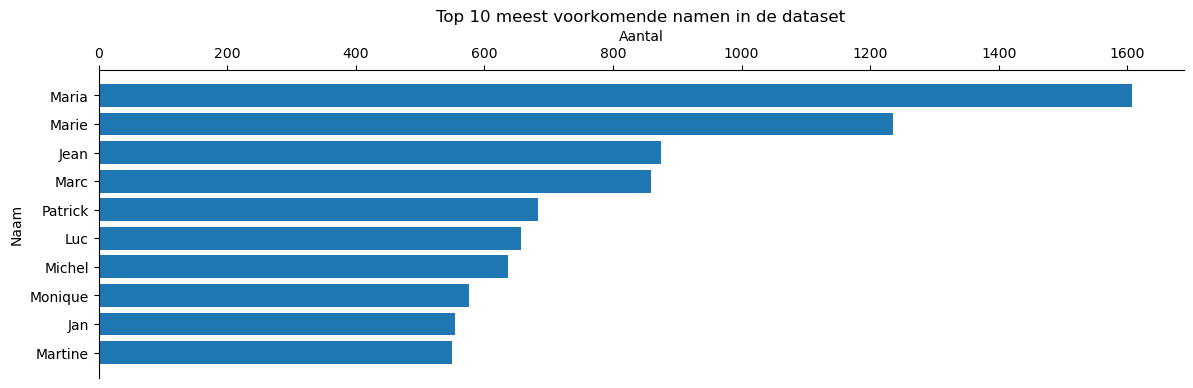

In [22]:
# Count occurrences of each name
name_counts = births_xtracols_cleaned_df['naam'].value_counts()

num_unique_names = len(name_counts)
total_names = len(births_xtracols_cleaned_df)  # total number of names
percentage_unique_names = to_percentage(num_unique_names / total_names)
number_of_names_once = np.sum(name_counts == 1)

print("Het aantal unieke namen:", num_unique_names)
print("Het percentage unieke namen:", percentage_unique_names)
print("Het aantal namen dat slechts één keer voorkomt:", number_of_names_once)

# Select the top 10 most common names
top_names = name_counts.head(10)

# Plot horizontal bar plot
horizontal_bar_plot(data=top_names, 
                    title="Top 10 meest voorkomende namen in de dataset", 
                    x_label="Aantal", 
                    y_label="Naam")

De rang van de naam waar de cumulatieve verdelingsfunctie 0.5 overschrijdt: 225


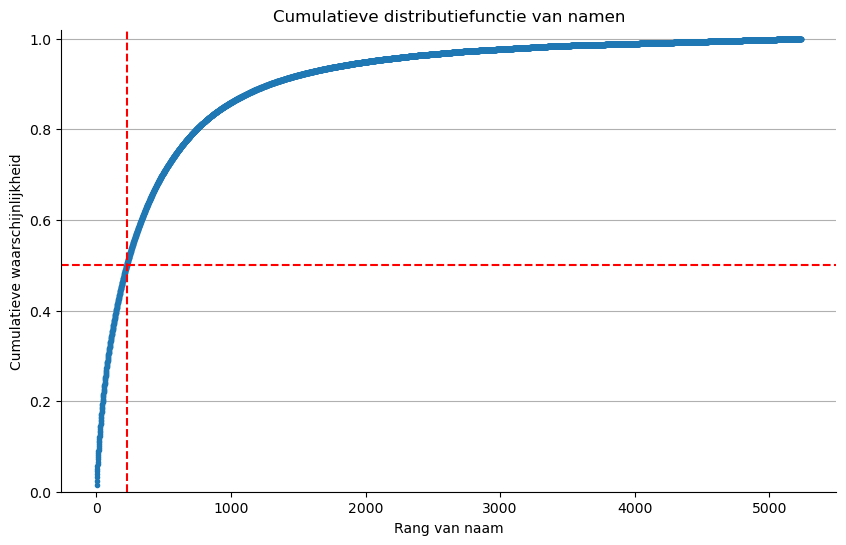

In [23]:
# Compute the number of occurrences for each name
name_counts = births_xtracols_cleaned_df['naam'].value_counts()

# Calculate the cumulative distribution of occurrence frequencies
cdf_values = np.cumsum(name_counts.values) / np.sum(name_counts.values)

# Get the ranks of names
ranks = np.arange(1, len(name_counts) + 1)

# Find the rank where CDF crosses 0.5
rank_cross_50 = np.argmax(cdf_values >= 0.5) + 1  # Add 1 to convert index to rank
print("De rang van de naam waar de cumulatieve verdelingsfunctie 0.5 overschrijdt:", rank_cross_50)

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(ranks, cdf_values, marker='.', linestyle='-')
plt.title('Cumulatieve distributiefunctie van namen')
plt.xlabel('Rang van naam')
plt.ylabel('Cumulatieve waarschijnlijkheid')
plt.grid(axis='y')  # Only show horizontal gridlines
plt.ylim(0, 1.02)
plt.gca().spines['top'].set_visible(False)  # Hide top spine
plt.gca().spines['right'].set_visible(False)  # Hide right spine
plt.axhline(y=0.5, color='red', linestyle='--')
plt.axvline(x=rank_cross_50, color='red', linestyle='--')
plt.show()

De rang van de naam waar de cumulatieve verdelingsfunctie 0.5 overschrijdt: 225


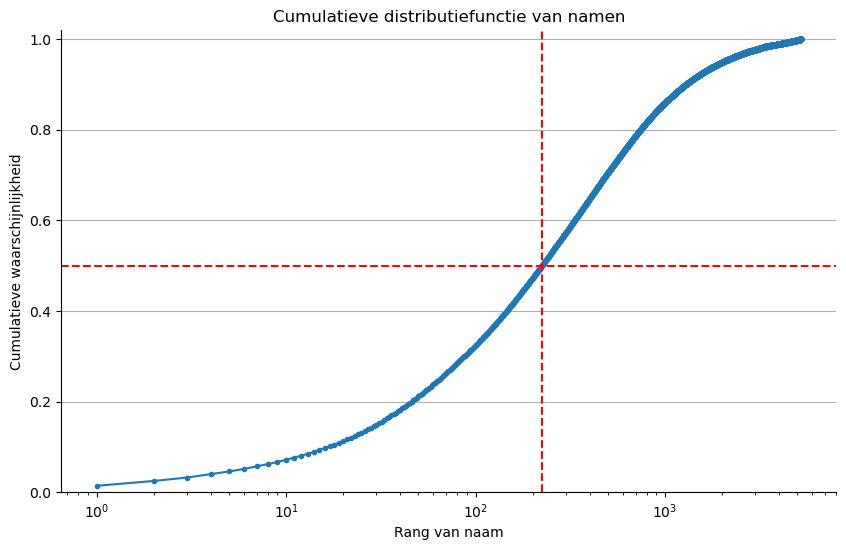

In [24]:

# Your existing code to compute name_counts, CDF values, and ranks
name_counts = births_xtracols_cleaned_df['naam'].value_counts()

# Calculate the cumulative distribution of occurrence frequencies
cdf_values = np.cumsum(name_counts.values) / np.sum(name_counts.values)

# Get the ranks of names
ranks = np.arange(1, len(name_counts) + 1)

# Find the rank where CDF crosses 0.5
rank_cross_50 = np.argmax(cdf_values >= 0.5) + 1  # Add 1 to convert index to rank
print("De rang van de naam waar de cumulatieve verdelingsfunctie 0.5 overschrijdt:", rank_cross_50)

# Plot the CDF with a logarithmic x-axis
plt.figure(figsize=(10, 6))
plt.plot(ranks, cdf_values, marker='.', linestyle='-')
plt.title('Cumulatieve distributiefunctie van namen')
plt.xlabel('Rang van naam')
plt.ylabel('Cumulatieve waarschijnlijkheid')
plt.grid(axis='y')  # Only show horizontal gridlines
plt.ylim(0, 1.02)
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.gca().spines['top'].set_visible(False)  # Hide top spine
plt.gca().spines['right'].set_visible(False)  # Hide right spine
plt.axhline(y=0.5, color='red', linestyle='--')
plt.axvline(x=rank_cross_50, color='red', linestyle='--')
plt.show()

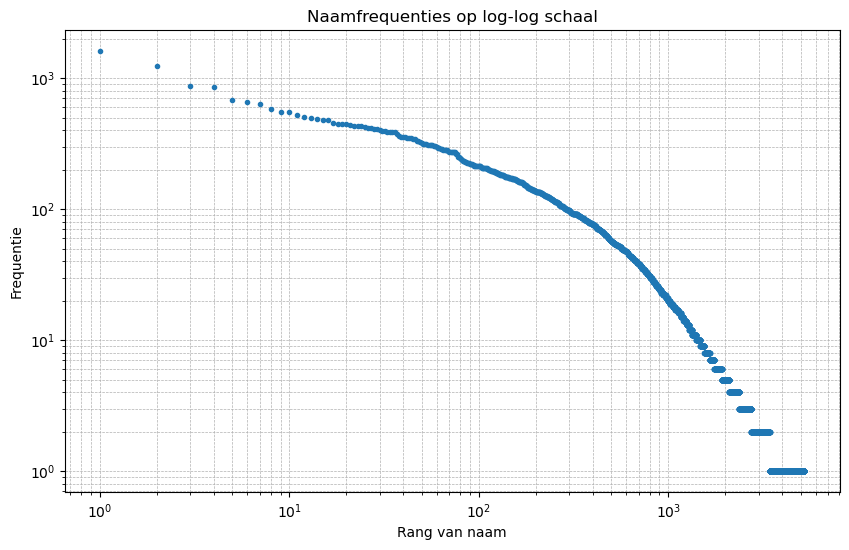

In [25]:
# Assuming name_counts is already calculated
name_counts = births_xtracols_cleaned_df['naam'].value_counts()

# Get the ranks of names
ranks = np.arange(1, len(name_counts) + 1)

# Plot the name frequencies on a log-log scale
plt.figure(figsize=(10, 6))
plt.plot(ranks, name_counts.values, marker='.', linestyle='none')
plt.title('Naamfrequenties op log-log schaal')
plt.xlabel('Rang van naam')
plt.ylabel('Frequentie')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()